In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set plot defaults
sns.set()                       # sets default plot style
sns.set_context("paper")        # sets default plot context
plt.rc('figure', figsize=(8,8))# sets default figure size
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc(['xtick', 'ytick'], labelsize=12)   # fontsize of the tick labels
plt.rc('legend', fontsize=14, title_fontsize= 14, loc='best')   # fontsize of the legend labels

# Read files with training dataset and cancer labels into pandas DataFrames
file = 'cardio_train.csv'
data = pd.read_csv(file, sep=';', header=0, index_col=0)

# Convert 'age' units from days to years
data['age'] = round((data['age'] / 365), 2)

# Convert 'height' units from cm to m
data['height'] = data['height']/100

# Add column that calculates BMI (body mass index)
data['BMI'] = round((data['weight'] / data['height']**2), 1)

# Filter out height outliers
df = data[(data.height >= 1.2) & (data.height <= 2.1)]

# Filter out abnormal blood pressure readings
df = df[(df.ap_hi < 300) & (df.ap_hi > 50) & (df.ap_lo > 20) & (df.ap_lo < 300)]

# Filter out BMI outliers
df = df[(df.BMI > 10)]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68726 entries, 0 to 99999
Data columns (total 13 columns):
age            68726 non-null float64
gender         68726 non-null int64
height         68726 non-null float64
weight         68726 non-null float64
ap_hi          68726 non-null int64
ap_lo          68726 non-null int64
cholesterol    68726 non-null int64
gluc           68726 non-null int64
smoke          68726 non-null int64
alco           68726 non-null int64
active         68726 non-null int64
cardio         68726 non-null int64
BMI            68726 non-null float64
dtypes: float64(4), int64(9)
memory usage: 7.3 MB
None


In [3]:
# Replace categorigal features with dummy columns
df_dummy = pd.get_dummies(df, columns=['gender', 'cholesterol', 'gluc'], prefix=['gender', 'chol', 'gluc'])
df_dummy = df_dummy.drop(['gender_2'], axis=1)

# Convert all data to float64 datatype
df_dummy = df_dummy.astype('float')

# Drop redundant height and weight columns
df_dummy_trim = df_dummy.drop(['height', 'weight',], axis=1)

X = df_dummy_trim.drop('cardio', axis=1)
y = df_dummy_trim.cardio
print(X.head())

      age  ap_hi  ap_lo  smoke  alco  active   BMI  gender_1  chol_1  chol_2  \
id                                                                             
0   50.39  110.0   80.0    0.0   0.0     1.0  22.0       0.0     1.0     0.0   
1   55.42  140.0   90.0    0.0   0.0     1.0  34.9       1.0     0.0     0.0   
2   51.66  130.0   70.0    0.0   0.0     0.0  23.5       1.0     0.0     0.0   
3   48.28  150.0  100.0    0.0   0.0     1.0  28.7       0.0     1.0     0.0   
4   47.87  100.0   60.0    0.0   0.0     0.0  23.0       1.0     1.0     0.0   

    chol_3  gluc_1  gluc_2  gluc_3  
id                                  
0      0.0     1.0     0.0     0.0  
1      1.0     1.0     0.0     0.0  
2      1.0     1.0     0.0     0.0  
3      0.0     1.0     0.0     0.0  
4      0.0     1.0     0.0     0.0  


Feature Ranking:
1. age (0.319680)
2. BMI (0.275311)
3. ap_hi (0.191626)
4. ap_lo (0.108278)
5. chol_3 (0.022585)
6. chol_1 (0.017237)
7. gender_1 (0.016230)
8. active (0.013567)
9. smoke (0.009449)
10. alco (0.007916)
11. gluc_1 (0.005582)
12. chol_2 (0.005413)
13. gluc_3 (0.004037)
14. gluc_2 (0.003087)


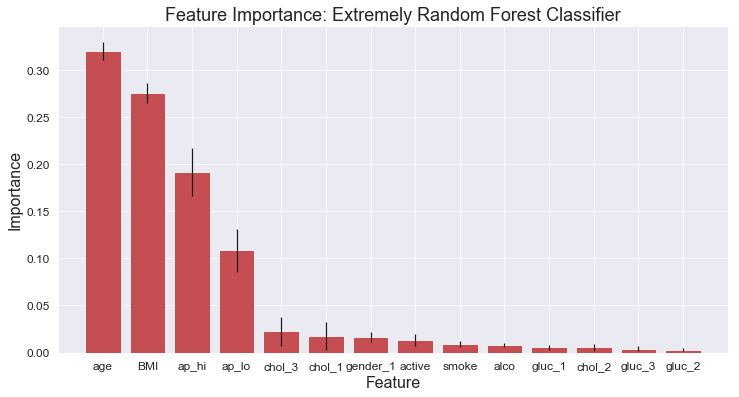

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=1582, stratify=y)

# Build an extremely randomized forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500, random_state=88)
forest.fit(X_train, y_train)
features = np.array(X_train.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title('Feature Importance: Extremely Random Forest Classifier')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices])
plt.xlim([-1, X_train.shape[1]])
plt.savefig(fname='images/features_extraTrees.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Feature Ranking:
1. age (0.329553)
2. BMI (0.268575)
3. ap_hi (0.183588)
4. ap_lo (0.096929)
5. chol_3 (0.021055)
6. gender_1 (0.020175)
7. active (0.017778)
8. chol_1 (0.015272)
9. smoke (0.010754)
10. alco (0.008571)
11. gluc_1 (0.007952)
12. chol_2 (0.007412)
13. gluc_3 (0.006828)
14. gluc_2 (0.005557)


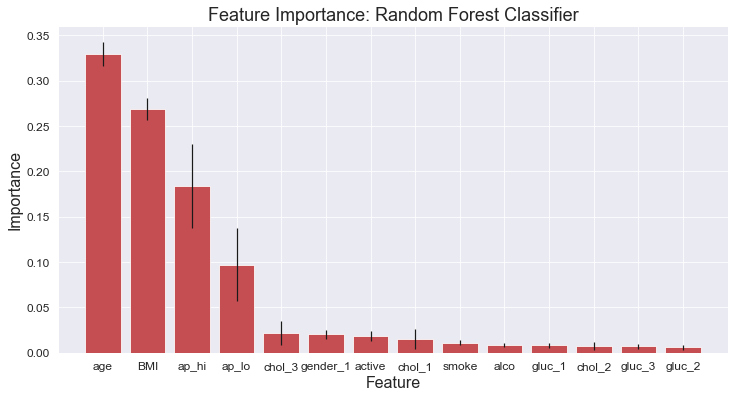

In [5]:
# Build a random forest and compute the feature importances
rand_forest = RandomForestClassifier(n_estimators=500, random_state=88)
rand_forest.fit(X_train, y_train)
features = np.array(X_train.columns)
importances = rand_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title('Feature Importance: Random Forest Classifier')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices])
plt.xlim([-1, X_train.shape[1]])
plt.savefig(fname='images/features_randomForest.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Feature Ranking:
1. ap_hi (0.537605)
2. age (0.217073)
3. BMI (0.090164)
4. chol_3 (0.057485)
5. ap_lo (0.036950)
6. active (0.017833)
7. chol_1 (0.009141)
8. gender_1 (0.006598)
9. smoke (0.005505)
10. alco (0.005196)
11. gluc_3 (0.004902)
12. chol_2 (0.004309)
13. gluc_2 (0.003977)
14. gluc_1 (0.003262)


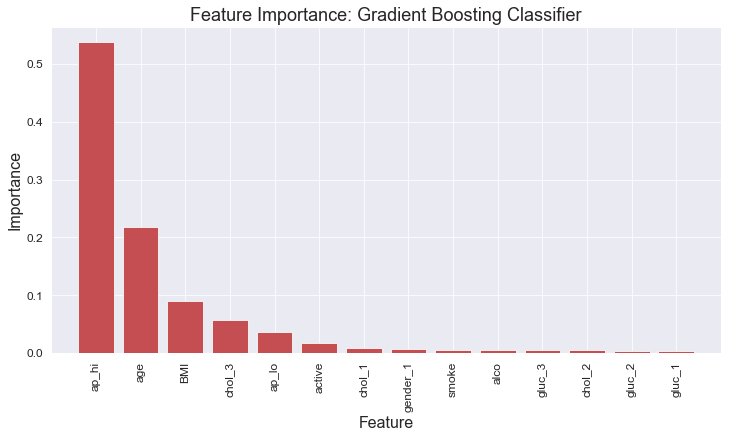

In [6]:
# Fit GradientBoostingClassifier and compute feature importances
gbc = GradientBoostingClassifier(n_estimators=500)
gbc.fit(X_train, y_train)
features = X_train.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances from the gbc
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), features[indices], rotation='vertical')
plt.xlim([-1, len(importances)])
plt.title('Feature Importance: Gradient Boosting Classifier')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.savefig(fname="images/features_GBClassifier.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [7]:
# Create the RFE object and rank each feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(estimator=logreg, n_features_to_select=5, step=1)
rfe.fit(X_train_scaled, y_train)

rankings = pd.DataFrame(data={'rank':rfe.ranking_, 'feature':X_train.columns})
rankings.set_index('rank', inplace=True)
rankings.sort_index(inplace=True)
rankings

,feature
rank,
1,age
1,ap_hi
1,BMI
1,chol_1
1,chol_3
2,active
3,ap_lo
4,alco
5,gluc_3


Optimal number of features : 4
Features: ['age' 'ap_hi' 'ap_lo' 'chol_3']


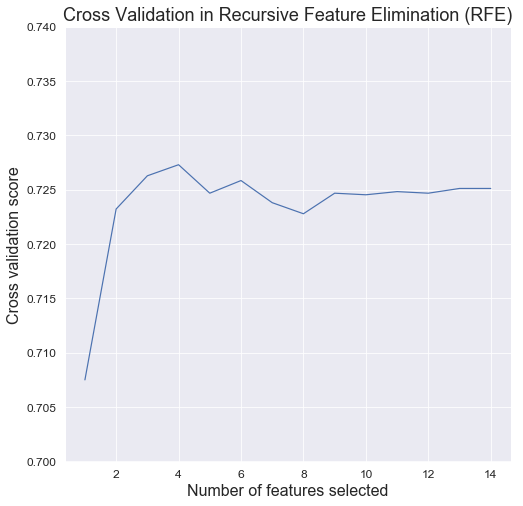

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg = LogisticRegression(solver='lbfgs', C=0.01)
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Features: {}".format(X_train.loc[:,rfecv.support_].columns.values))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,8))
plt.title("Cross Validation in Recursive Feature Elimination (RFE)")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.ylim([0.7, 0.74])
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig(fname="images/features_RFEcv.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [9]:
X_train_full = X_train
X_test_full = X_test

In [10]:
# Create X_train and X_test with minimal feature set
X_train = X_train[['age', 'ap_hi', 'ap_lo', 'BMI', 'chol_3']]
X_test = X_test[['age', 'ap_hi', 'ap_lo', 'BMI', 'chol_3']]

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    7.3s finished


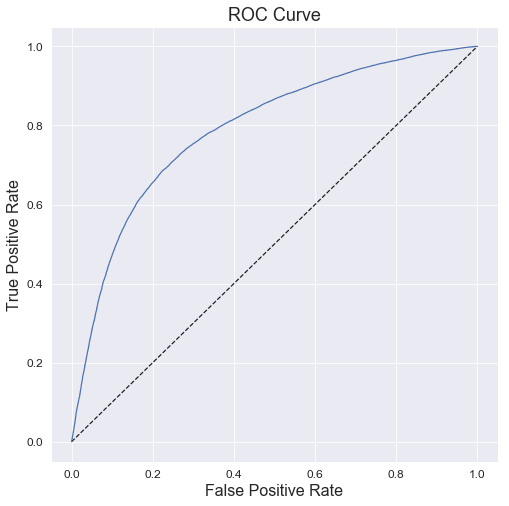

AUC is 0.79
Best C is 0.1
Best solver is lbfgs
Accuracy: 73.02%

Confusion matrix: 
[[24538  6705]
 [ 9982 20629]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     31243
         1.0       0.75      0.67      0.71     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [11]:
# Logistic Regression classifier using full feature set (except height & weight)
# Initiate logistic regression pipeline
logreg_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# Set parameters to test
parameters = {'logreg__C': np.logspace(-5, 5, 11), 'logreg__solver': ['lbfgs', 'newton-cg', 'sag']}

# Perform GridSearch on list of parameters, then fit the model
logreg_cv = GridSearchCV(logreg_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
logreg_cv.fit(X_train_full, y_train)
logreg_y_pred = logreg_cv.predict(X_test_full)

# Compute predicted probabilities of test set labels
y_pred_prob = logreg_cv.predict_proba(X_test_full)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.rc('figure', figsize=(8,8)) # sets default figure size
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/logreg_full.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print classification metrics
print('Best C is {}'.format(logreg_cv.best_params_['logreg__C']))
print('Best solver is {}'.format(logreg_cv.best_params_['logreg__solver']))
#print('Best regularization is {}'.format(logreg_cv.best_params_['logreg__penalty']))
print('Accuracy: {:.2%}\n'.format(logreg_cv.score(X_test_full, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, logreg_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, logreg_y_pred)))

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    4.9s finished


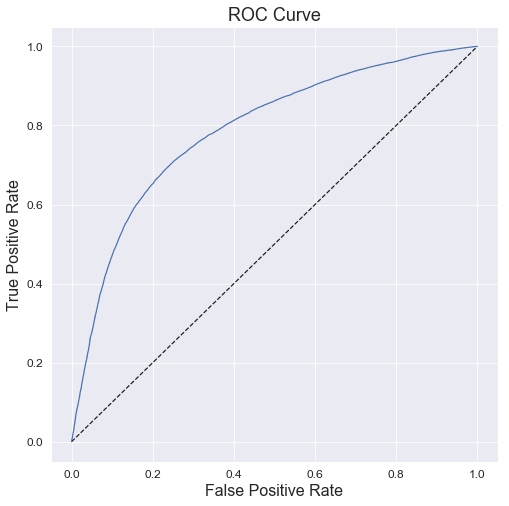

AUC is 0.79
Best C is 1.0
Best solver is lbfgs
Accuracy: 72.85%

Confusion matrix: 
[[24690  6553]
 [10243 20368]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     31243
         1.0       0.76      0.67      0.71     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [12]:
# Logistic Regression classifier using reduced feature set
# Initiate logistic regression pipeline
logreg_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# Set parameters to test
parameters = {'logreg__C': np.logspace(-5, 5, 11), 'logreg__solver': ['lbfgs', 'newton-cg', 'sag']}

# Perform GridSearch on list of parameters, then fit the model
logreg_cv = GridSearchCV(logreg_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
logreg_cv.fit(X_train, y_train)
logreg_y_pred = logreg_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/logreg_reduced.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print classification metrics
print('Best C is {}'.format(logreg_cv.best_params_['logreg__C']))
print('Best solver is {}'.format(logreg_cv.best_params_['logreg__solver']))
#print('Best regularization is {}'.format(logreg_cv.best_params_['logreg__penalty']))
print('Accuracy: {:.2%}\n'.format(logreg_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, logreg_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, logreg_y_pred)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 29.9min finished


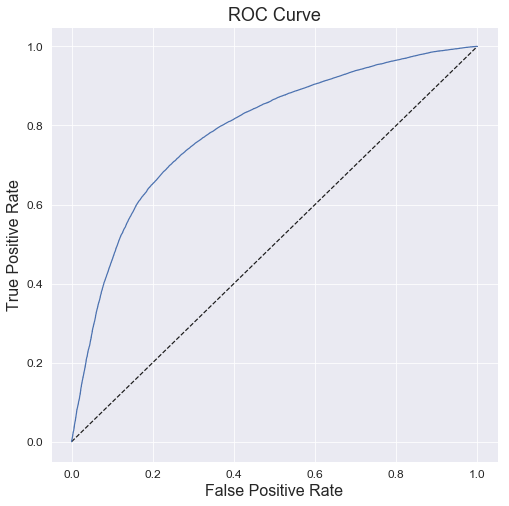

AUC is 0.79
Best C is 1.0
Best gamma is 0.001

Accuracy: 72.48%

Confusion matrix: 
[[25514  5729]
 [11291 19320]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75     31243
         1.0       0.77      0.63      0.69     30611

   micro avg       0.72      0.72      0.72     61854
   macro avg       0.73      0.72      0.72     61854
weighted avg       0.73      0.72      0.72     61854



In [13]:
# Support Vector Classifier using full feature set (except height & weight)

# Initiate SVC pipeline
svc_pipeline = Pipeline(steps=[('scaler', StandardScaler()),('svc', SVC(cache_size=1000, probability=True))])

# Set parameters to test
parameters = {'svc__C': np.logspace(-3, 3, 7), 'svc__gamma': np.logspace(-6, 3, 10)}

# Perform GridSearch on list of parameters, then fit the model
svc_cv = RandomizedSearchCV(svc_pipeline, param_distributions=parameters, cv=5, iid=False, verbose=1, n_iter=20)
svc_cv.fit(X_train_full, y_train)
svc_y_pred = svc_cv.predict(X_test_full)

# Compute predicted probabilities of test set labels
y_pred_prob = svc_cv.predict_proba(X_test_full)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/svc_full.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best C is {}'.format(svc_cv.best_params_['svc__C']))
print('Best gamma is {}\n'.format(svc_cv.best_params_['svc__gamma']))
print('Accuracy: {:.2%}\n'.format(svc_cv.score(X_test_full, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, svc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, svc_y_pred)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 41.0min finished


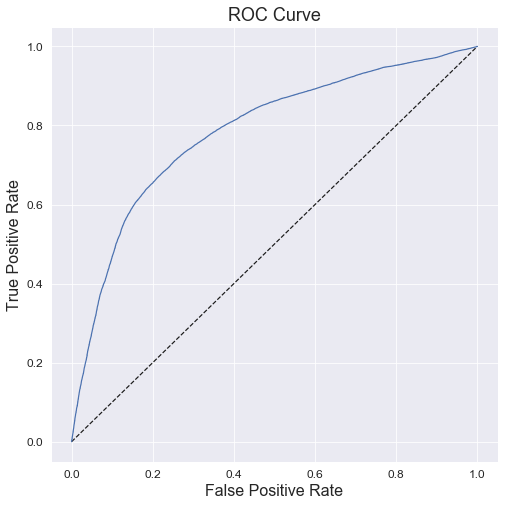

AUC is 0.78
Best C is 1.0
Best gamma is 0.1

Accuracy: 72.81%

Confusion matrix: 
[[25366  5877]
 [10941 19670]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75     31243
         1.0       0.77      0.64      0.70     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [14]:
# Support Vector Classifier using reduced feature set

# Initiate SVC pipeline
svc_pipeline = Pipeline(steps=[('scaler', StandardScaler()),('svc', SVC(cache_size=1000, probability=True))])

# Set parameters to test
parameters = {'svc__C': np.logspace(-3, 3, 7), 'svc__gamma': np.logspace(-6, 3, 10)}

# Perform GridSearch on list of parameters, then fit the model
svc_cv = RandomizedSearchCV(svc_pipeline, param_distributions=parameters, cv=5, iid=False, verbose=1, n_iter=20)
svc_cv.fit(X_train, y_train)
svc_y_pred = svc_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = svc_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/svc_reduced.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best C is {}'.format(svc_cv.best_params_['svc__C']))
print('Best gamma is {}\n'.format(svc_cv.best_params_['svc__gamma']))
print('Accuracy: {:.2%}\n'.format(svc_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, svc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, svc_y_pred)))

In [15]:
# Linear Support Vector Classifier (LinearSVC) using full feature set (except height & weight)
# Initiate scaler and classifier pipeline 
linsvc_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('linsvc', LinearSVC(dual=False, max_iter=1000))])

# Set parameters to test
parameters = {'linsvc__C': np.logspace(-5, 5, 11)}

# Perform GridSearch on list of parameters, then fit the model
linsvc_cv = GridSearchCV(linsvc_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
linsvc_cv.fit(X_train_full, y_train)
linsvc_y_pred = linsvc_cv.predict(X_test_full)

# Print out classification metrics
print('Best C is {}'.format(linsvc_cv.best_params_['linsvc__C']))
print('Accuracy: {:.2%}\n'.format(linsvc_cv.score(X_test_full, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, linsvc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, linsvc_y_pred)))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.8s finished


Best C is 0.1
Accuracy: 72.85%

Confusion matrix: 
[[24727  6516]
 [10280 20331]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     31243
         1.0       0.76      0.66      0.71     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [16]:
# Linear Support Vector Classifier (LinearSVC) using full feature set (except height & weight)
# Initiate scaler and classifier pipeline 
linsvc_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('linsvc', LinearSVC(dual=False, max_iter=1000))])

# Set parameters to test
parameters = {'linsvc__C': np.logspace(-5, 5, 11)}

# Perform GridSearch on list of parameters, then fit the model
linsvc_cv = GridSearchCV(linsvc_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
linsvc_cv.fit(X_train, y_train)
linsvc_y_pred = linsvc_cv.predict(X_test)

# Print out classification metrics
print('Best C is {}'.format(linsvc_cv.best_params_['linsvc__C']))
print('Accuracy: {:.2%}\n'.format(linsvc_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, linsvc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, linsvc_y_pred)))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished


Best C is 0.01
Accuracy: 72.72%

Confusion matrix: 
[[24870  6373]
 [10500 20111]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75     31243
         1.0       0.76      0.66      0.70     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   48.1s finished


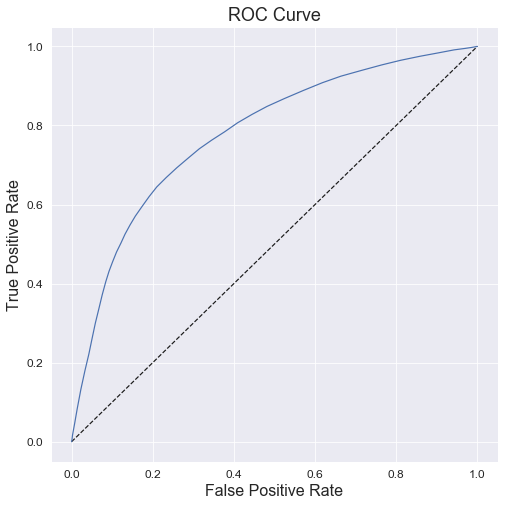

AUC is 0.78
Best n_neighbors is 50

Accuracy: 71.80%

Confusion matrix: 
[[24680  6563]
 [10880 19731]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74     31243
         1.0       0.75      0.64      0.69     30611

   micro avg       0.72      0.72      0.72     61854
   macro avg       0.72      0.72      0.72     61854
weighted avg       0.72      0.72      0.72     61854



In [17]:
# K-Nearest Neighbors Classifier using full feature set (except height & weight)
# Initiate scaler, kNN Classifier, and pipeline
knn_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(algorithm='kd_tree'))])

# Set list of parameters to test
parameters = {'knn__n_neighbors': [5, 25, 50, 100, 150, 200, 250, 300]}

# Perform GridSearch on list of parameters, then fit the model
knn_cv = GridSearchCV(knn_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
knn_cv.fit(X_train_full, y_train)
y_pred = knn_cv.predict(X_test_full)

# Compute predicted probabilities of test set labels
y_pred_prob = knn_cv.predict_proba(X_test_full)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/knn_full.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best n_neighbors is {}\n'.format(knn_cv.best_params_['knn__n_neighbors']))
print('Accuracy: {:.2%}\n'.format(knn_cv.score(X_test_full, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, y_pred)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.7s finished


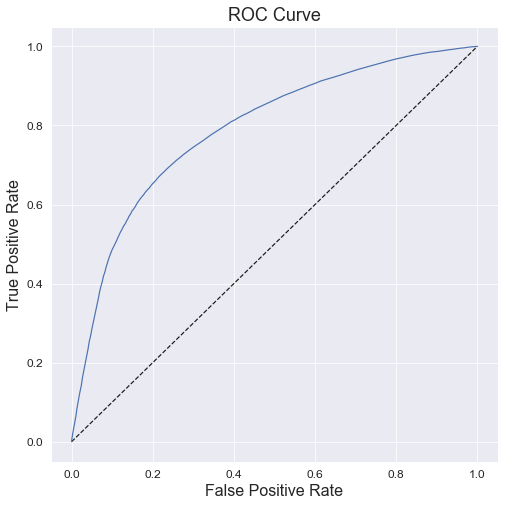

AUC is 0.79
Best n_neighbors is 200

Accuracy: 72.59%

Confusion matrix: 
[[25258  5985]
 [10970 19641]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75     31243
         1.0       0.77      0.64      0.70     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.72     61854
weighted avg       0.73      0.73      0.72     61854



In [18]:
# K-Nearest Neighbors Classifier using reduced feature set
# Initiate scaler, kNN Classifier, and pipeline
knn_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(algorithm='kd_tree'))])

# Set list of parameters to test
parameters = {'knn__n_neighbors': [5, 25, 50, 100, 150, 200, 250, 300]}

# Perform GridSearch on list of parameters, then fit the model
knn_cv = GridSearchCV(knn_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = knn_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/knn_reduced.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best n_neighbors is {}\n'.format(knn_cv.best_params_['knn__n_neighbors']))
print('Accuracy: {:.2%}\n'.format(knn_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, y_pred)))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.7min finished


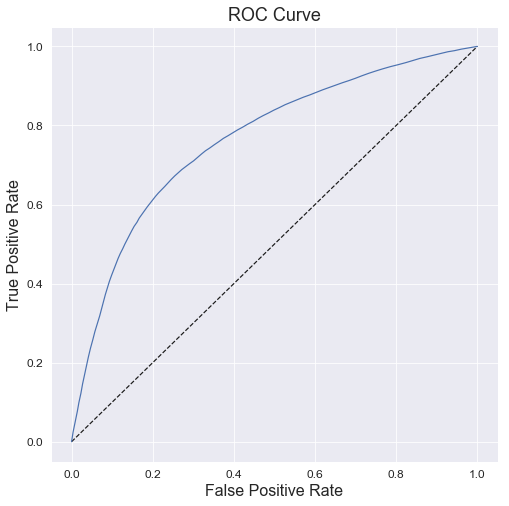

AUC is 0.77
Best n_estimators is: 100

Best max_features is: 5

Accuracy: 70.75%

Confusion matrix: 
[[22461  8782]
 [ 9312 21299]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     31243
         1.0       0.71      0.70      0.70     30611

   micro avg       0.71      0.71      0.71     61854
   macro avg       0.71      0.71      0.71     61854
weighted avg       0.71      0.71      0.71     61854



In [19]:
# Random Forest Classifier using full feature set (except height & weight)
# Initiate RandomForest pipeline
rfc_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=42))])

# Set parameters to test
parameters = {'rfc__n_estimators': [50, 100, 250, 500], 
              'rfc__max_features': np.arange(1, 9, 1)}

# Perform GridSearch on list of parameters, then fit the model
rfc_cv = GridSearchCV(rfc_pipeline, param_grid=parameters, cv=5, iid=False, return_train_score=False, verbose=1)
rfc_cv.fit(X_train_full, y_train)
rfc_y_pred = rfc_cv.predict(X_test_full)

# Compute predicted probabilities of test set labels
y_pred_prob = rfc_cv.predict_proba(X_test_full)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/rfc_full.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best n_estimators is: {}\n'.format(rfc_cv.best_params_['rfc__n_estimators']))
print('Best max_features is: {}\n'.format(rfc_cv.best_params_['rfc__max_features']))
print('Accuracy: {:.2%}\n'.format(rfc_cv.score(X_test_full, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, rfc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, rfc_y_pred)))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  5.5min finished


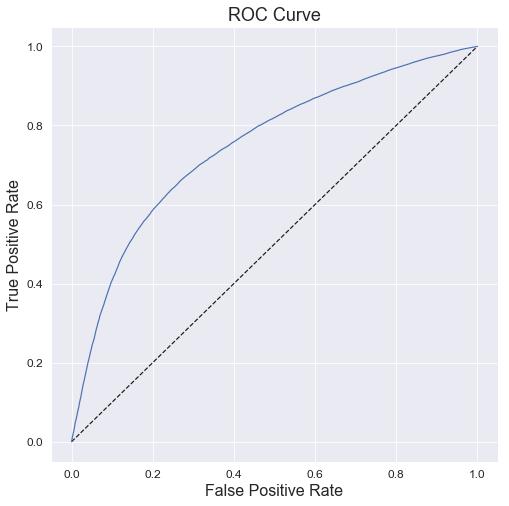

AUC is 0.75
Best n_estimators is: 500

Best max_features is: 3

Accuracy: 69.38%

Confusion matrix: 
[[22016  9227]
 [ 9710 20901]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.70     31243
         1.0       0.69      0.68      0.69     30611

   micro avg       0.69      0.69      0.69     61854
   macro avg       0.69      0.69      0.69     61854
weighted avg       0.69      0.69      0.69     61854



In [20]:
# Random Forest Classifier using reduced feature set (except height & weight)
# Initiate RandomForest pipeline
rfc_pipeline = Pipeline(steps=[('scaler', StandardScaler()),('rfc', RandomForestClassifier(random_state=42))])

# Set parameters to test
parameters = {'rfc__n_estimators': [10, 25, 50, 75, 100, 500, 750, 1000], 
              'rfc__max_features': np.arange(1, 5, 1)}

# Perform GridSearch on list of parameters, then fit the model
rfc_cv = GridSearchCV(rfc_pipeline, param_grid=parameters, cv=5, iid=False, return_train_score=False, verbose=1)
rfc_cv.fit(X_train, y_train)
rfc_y_pred = rfc_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = rfc_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/rfc_reduced.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best n_estimators is: {}\n'.format(rfc_cv.best_params_['rfc__n_estimators']))
print('Best max_features is: {}\n'.format(rfc_cv.best_params_['rfc__max_features']))
print('Accuracy: {:.2%}\n'.format(rfc_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, rfc_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, rfc_y_pred)))

In [21]:
X = df_dummy.drop('cardio', axis=1)
y = df_dummy.cardio
print(X.head())

      age  height  weight  ap_hi  ap_lo  smoke  alco  active   BMI  gender_1  \
id                                                                             
0   50.39    1.68    62.0  110.0   80.0    0.0   0.0     1.0  22.0       0.0   
1   55.42    1.56    85.0  140.0   90.0    0.0   0.0     1.0  34.9       1.0   
2   51.66    1.65    64.0  130.0   70.0    0.0   0.0     0.0  23.5       1.0   
3   48.28    1.69    82.0  150.0  100.0    0.0   0.0     1.0  28.7       0.0   
4   47.87    1.56    56.0  100.0   60.0    0.0   0.0     0.0  23.0       1.0   

    chol_1  chol_2  chol_3  gluc_1  gluc_2  gluc_3  
id                                                  
0      1.0     0.0     0.0     1.0     0.0     0.0  
1      0.0     0.0     1.0     1.0     0.0     0.0  
2      0.0     0.0     1.0     1.0     0.0     0.0  
3      1.0     0.0     0.0     1.0     0.0     0.0  
4      1.0     0.0     0.0     1.0     0.0     0.0  


Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    4.8s finished


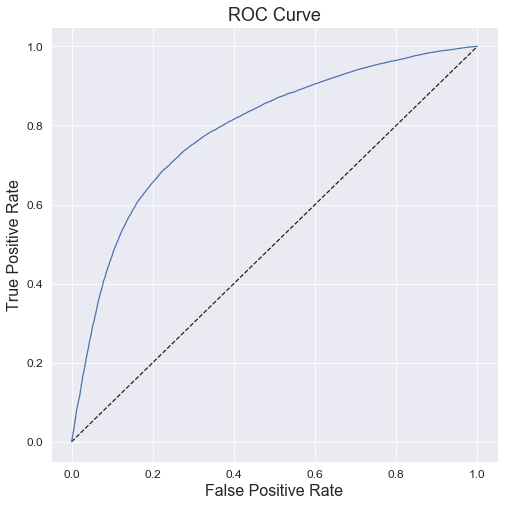

AUC is 0.79
Best C is 0.1
Best solver is lbfgs
Accuracy: 73.02%

Confusion matrix: 
[[24536  6707]
 [ 9980 20631]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     31243
         1.0       0.75      0.67      0.71     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [22]:
# Drop features and try LogisticRegression classifier
X = X.drop(['height', 'weight', 'smoke', 'gluc_1'], axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=1582, stratify=y)

# Initiate logistic regression pipeline
logreg_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# Set parameters to test
parameters = {'logreg__C': np.logspace(-5, 5, 11), 'logreg__solver': ['lbfgs', 'newton-cg', 'sag']}

# Perform GridSearch on list of parameters, then fit the model
logreg_cv = GridSearchCV(logreg_pipeline, param_grid=parameters, cv=5, iid=False, verbose=1)
logreg_cv.fit(X_train, y_train)
logreg_y_pred = logreg_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/logreg_best.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print classification metrics
print('Best C is {}'.format(logreg_cv.best_params_['logreg__C']))
print('Best solver is {}'.format(logreg_cv.best_params_['logreg__solver']))
#print('Best regularization is {}'.format(logreg_cv.best_params_['logreg__penalty']))
print('Accuracy: {:.2%}\n'.format(logreg_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, logreg_y_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, logreg_y_pred)))

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 880 out of 880 | elapsed:   18.0s finished


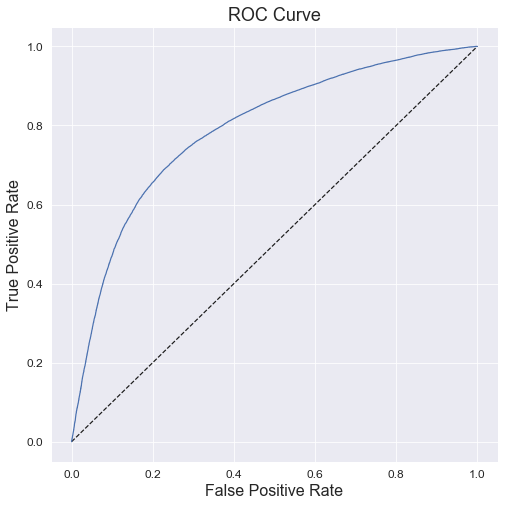

AUC is 0.79
Best C is 100.0
Best n_components is 13

Accuracy: 73.00%

Confusion matrix: 
[[24536  6707]
 [ 9993 20618]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     31243
         1.0       0.75      0.67      0.71     30611

   micro avg       0.73      0.73      0.73     61854
   macro avg       0.73      0.73      0.73     61854
weighted avg       0.73      0.73      0.73     61854



In [23]:
from sklearn.decomposition import PCA

# Reset X and y
X = df_dummy.drop('cardio', axis=1)
y = df_dummy.cardio

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=1582, stratify=y)

# Initiate pipeline for normalization, PCA reduction, and k-nearest neighbors classification
pca_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), 
                               ('logreg', LogisticRegression(solver='lbfgs'))])

# Set parameters to test with GridSearchCV
pca_params = {'pca__n_components': range(1, 17), 'logreg__C': np.logspace(-5, 5, 11)}

# Perform GridSearch on list of parameters, then fit the model
pca_cv = GridSearchCV(pca_pipeline, param_grid=pca_params, cv=5, iid=False, verbose=1)
pca_cv.fit(X_train, y_train)
y_pred_pca = pca_cv.predict(X_test)

# Compute predicted probabilities of test set labels
y_pred_prob = pca_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(fname="images/pca_full.png", dpi='figure', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print('AUC is {}'.format(round(roc_auc_score(y_test, y_pred_prob), 2)))

# Print out classification metrics
print('Best C is {}'.format(pca_cv.best_params_['logreg__C']))
print('Best n_components is {}\n'.format(pca_cv.best_params_['pca__n_components']))
print('Accuracy: {:.2%}\n'.format(pca_cv.score(X_test, y_test)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred_pca)))
print('Classification report: \n{}'.format(classification_report(y_test, y_pred_pca)))